In [17]:
import numpy as np
import pandas as pd
import warnings
import os
from datasets import load_dataset
from lambeq import BobcatParser
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## 1) Read in the data and create diagrams

### Skip below cell

In [18]:
### Still working on getting this cell to work. Bobcatarser cannot parse some sentences
# def read_sst2(data_type="train"):
#     dataset = load_dataset("gpt3mix/sst2")

#     data = dataset[data_type]

#     usr_data = []
#     usr_labels = []

#     for example in data:
#         usr_data.append(example["text"])
#         usr_labels.append(example["label"])

#     print("First sentence:", usr_data[0])
#     print("First label:", usr_labels[0])

#     return usr_data,usr_labels

# train_data,train_labels = read_sst2("train")
# dev_data,dev_labels = read_sst2("validation")
# test_data,test_labels = read_sst2("test")

In [19]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

Failed to update model with exception: ModelDownloader raised error: Failed to download model bert. Received response status code: 202
Attempting to continue with version 1.2.1


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


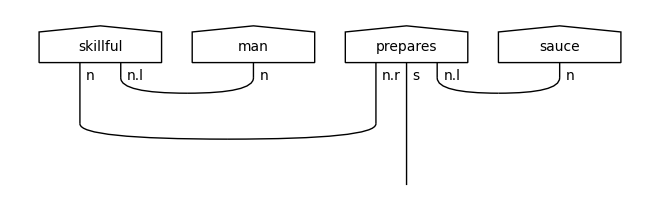

In [20]:
parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_dev_diagrams = parser.sentences2diagrams(dev_data)
raw_test_diagrams = parser.sentences2diagrams(test_data)

raw_train_diagrams[0].draw()

In [21]:
"""from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

print("Before removing cups")
raw_train_diagrams[0].draw()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

print("After removing cups")
train_diagrams[0].draw()
"""
## NOT REMOVING CUPS

train_diagrams = raw_train_diagrams
dev_diagrams = raw_dev_diagrams
test_diagrams = raw_test_diagrams



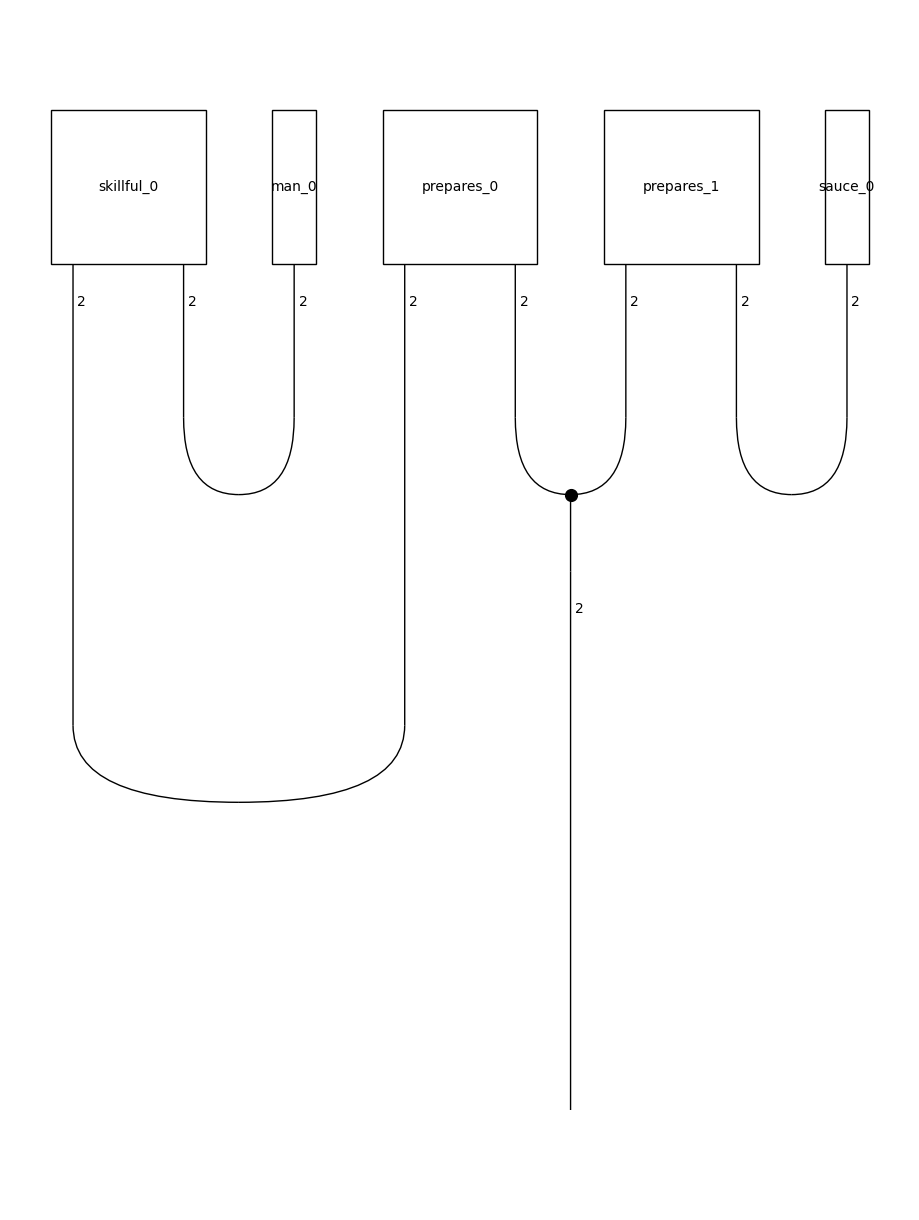

In [22]:
from lambeq import AtomicType, IQPAnsatz, BaseAnsatz, CircuitAnsatz, MPSAnsatz, Sim14Ansatz, Sim15Ansatz, SpiderAnsatz, StronglyEntanglingAnsatz, Symbol, TensorAnsatz

#ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
 #                  n_layers=1, n_single_qubit_params=3)

from lambeq.backend.tensor import Dim

N = AtomicType.NOUN
S = AtomicType.SENTENCE

# Create an ansatz 
ansatz = SpiderAnsatz({N: Dim(2), S: Dim(2)})

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 12))

# Step 5: Choosing a backend
We are now going to choose a backend on which our quantum circuits is going to be run. In this workshop we are going to use a classical simulator (a classical computer which simulates the bahaviour of a real quantum computer) to run our circuits. 

In [23]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits+dev_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

# Step 6: Creating the quantum sentence classifier. 

The code below trains our quantum sentence classifier. Since the training can take a few minutes we could alternatively work with a pre-trained model which you can load from the `checkpoint.pickle` file.

In [24]:
from lambeq import BinaryCrossEntropyLoss

#model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

import torch
from lambeq import PytorchModel

model = PytorchModel.from_diagrams(all_circuits)

# loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss

sig = torch.sigmoid

def acc(y_hat, y):
    return torch.sum(torch.eq(torch.round(sig(y_hat)), y))/len(y)/2  # half due to double-counting

eval_metrics = {"acc": acc}

from lambeq import QuantumTrainer, SPSAOptimizer

EPOCHS = 120
BATCH_SIZE = 30

from lambeq import PytorchTrainer


trainer = PytorchTrainer(
        model=model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=3e-2,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=0)



from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

In [25]:
trainer.fit(train_dataset, val_dataset, log_interval=1)

Epoch 1:    train/loss: 0.8890   valid/loss: 0.7460   train/acc: 0.5143   valid/acc: 0.5500
Epoch 2:    train/loss: 0.8245   valid/loss: 0.7331   train/acc: 0.5214   valid/acc: 0.5500
Epoch 3:    train/loss: 0.6963   valid/loss: 0.7249   train/acc: 0.5643   valid/acc: 0.5500
Epoch 4:    train/loss: 0.7319   valid/loss: 0.7187   train/acc: 0.5714   valid/acc: 0.5333
Epoch 5:    train/loss: 0.6518   valid/loss: 0.7119   train/acc: 0.5643   valid/acc: 0.5500
Epoch 6:    train/loss: 0.6340   valid/loss: 0.7024   train/acc: 0.6000   valid/acc: 0.5333
Epoch 7:    train/loss: 0.6133   valid/loss: 0.6900   train/acc: 0.6071   valid/acc: 0.5500
Epoch 8:    train/loss: 0.6698   valid/loss: 0.6706   train/acc: 0.6071   valid/acc: 0.6167
Epoch 9:    train/loss: 0.5143   valid/loss: 0.6460   train/acc: 0.5857   valid/acc: 0.6000
Epoch 10:   train/loss: 0.5804   valid/loss: 0.6197   train/acc: 0.5714   valid/acc: 0.6167
Epoch 11:   train/loss: 0.5401   valid/loss: 0.5884   train/acc: 0.6643   valid/

In [26]:
# model = TketModel.from_checkpoint('models/classifier-IQP.pickle', backend_config=backend_config)
model.save("models/classifier-Spider.pickle")

In [27]:
test_labels

[[1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [0, 1],
 [1, 0],
 [0, 1],
 [1, 0]]

In [28]:
def measure_model_performance():
    # np_test_circuits = [c.lambdify(*vocab)(*tensors) for c in test_circuits]
    # test_predictions =  sigmoid(np.array([c.eval(dtype=float) for c in np_test_circuits]))
    
    # hits = 0
    # for i in range(len(np_test_circuits)):
    #     target = test_targets[i]
    #     pred = test_predictions[i]
    #     if np.argmax(target) == np.argmax(pred):
    #         hits += 1
    
    # print("Accuracy on test set:", hits / len(np_test_circuits))
    # np_test_circuits = [c.lambdify(*vocab)(*tensors) for c in test_circuits]
    # test_dataset = Dataset(test_circuits, test_labels, shuffle=False)
    test_pred = model.get_diagram_output(test_circuits)
    # print(f"test acc: {test_acc:.4f}")
    total = 0
    for i in range(len(test_pred)):
        if test_pred[i][0]>=0.5:
            test_pred[i][0],test_pred[i][1]=1.0,0.0
        else:
            test_pred[i][0],test_pred[i][1]=0.0,1.0
        if test_pred[i][0]==test_labels[i][0] and test_pred[i][1]==test_labels[i][1]:
            total+=1
    return total/len(test_labels)
measure_model_performance()

1.0